In [243]:
import os
from gensim.models import KeyedVectors
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cosine, euclidean
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt

# import tensorflow as tf
# import tensorflow.contrib.eager as tfe
# tf.enable_eager_execution()

In [231]:
data_pth = '../../../../datasets/word-vector-datasets/glove/'
# model_fn = 'glove.6B.50d.w2vformat.txt'
model_fn = 'glove.840B.300d.w2vformat.txt'

binary = True
if 'glove' in model_fn: binary = False

model = KeyedVectors.load_word2vec_format(data_pth + model_fn, 
                                          binary=binary)

In [235]:
df_rel_sim = pd.read_csv('relsim_mean_ratings.csv')
df_rel_sim['rel1_type'] = df_rel_sim['relation1'].apply(lambda x: int(x[:-1]))
df_rel_sim['rel2_type'] = df_rel_sim['relation2'].apply(lambda x: int(x[:-1]))
df_rel_sim.head()

,relation1,relation2,comparison_type,pair1_word1,pair1_word2,pair2_word1,pair2_word2,mean_rating,num_ratings,rel1_type,rel2_type
0,3a,3a,within-subtype,candy,sweets,sofa,chair,3.750000,12,3,3
1,1a,1a,within-subtype,dollar,currency,wheat,bread,4.727273,11,1,1
2,9a,9a,within-subtype,store,shopper,supermarket,groceries,5.583333,12,9,9
3,6a,6a,within-subtype,classic,trendy,integrity,dishonest,3.700000,10,6,6
4,10a,10a,within-subtype,flashing,caution,green,go,6.583333,12,10,10


In [289]:
def words_in_vocab(words, model):
    
    status = True
    
    for w in words:
        if w not in model.vocab:
            status = False
            
    return status


def compute_similarity(u, v, metric='e'):
    
    if metric in ['inner product', 'ip']:
        return np.dot(u, v)
    
    elif metric in ['cosine', 'c']:
        return -cosine(u, v)
    
    elif metric in ['euclidean', 'e']:
        return 1 - euclidean(u, v)

    
def get_analogy_words(trial):
    
    return [trial.pair1_word1,
            trial.pair1_word2,
            trial.pair2_word1,
            trial.pair2_word2]


def get_word_vector(word, model, normalize=True):
    
    word_vector = model[word]
    
    if normalize:
        return word_vector / norm(word_vector)
    else:       
        return word_vector


def get_diff_vecs(words, model, dims=None):
    
    w1_vec = get_word_vector(words[0], model)
    w2_vec = get_word_vector(words[1], model)
    w3_vec = get_word_vector(words[2], model)
    w4_vec = get_word_vector(words[3], model)
    
    diff_pair1 = w1_vec - w2_vec
    diff_pair2 = w3_vec - w4_vec
    
    if dims is None:
        return diff_pair1, diff_pair2
    else:
        return diff_pair1[dims], diff_pair2[dims]
    

def naive_train_test_split(df, val_percent=0.2, shuffle=True):
    """ Doesn't avoid shared single words
        across train and test sets!!
    """
    train_percent = 1 - val_percent
    
    n = df.shape[0]
    idxs = np.arange(n)
    if shuffle: np.random.shuffle(idxs)
    
    train_idxs = idxs[:int(n*train_percent)]
    val_idxs = idxs[int(n*train_percent):]
    
    return train_idxs, val_idxs  


def score_preds(df):
    return pearsonr(df[df.in_vocab==True].mean_rating, 
                    df[df.in_vocab==True].preds)


def get_rel_sim_preds(df, model, dims=None,
                      metric='e'):
    
    preds, in_vocab = [], []
    for r, row in df.iterrows():
        
        words = get_analogy_words(row)
        
        if words_in_vocab(words, model):
        
            diff_pair1, diff_pair2 = \
                get_diff_vecs(words, model, dims=dims)
            
            sim = compute_similarity(diff_pair1, diff_pair2,
                                     metric=metric)
            preds.append(sim)
            in_vocab.append(True)
        else:
            preds.append(999)
            in_vocab.append(False)
        
    df['preds'] = preds
    df['in_vocab'] = in_vocab
    return df

def search_for_best_axes(df, model, epsilon=0, verbose=0):
    """ Find the subset of dimensions (axis-aligned subspace)
        giving the best fit to human data.
    """
    
    n_feats = model['dog'].size
    feat_idx_keep = np.arange(n_feats)
    
    df_pred = get_rel_sim_preds(df, model)
    base_score = score_preds(df_pred)[0]
    best_score = base_score
    if verbose > 0:
        print('Base Score : %.4f, Features: %i' % (best_score, n_feats))
    
    for feat_idx in np.arange(n_feats):
        
        curr_feat_set_proposal = feat_idx_keep[feat_idx_keep!=feat_idx]

        df_pred = get_rel_sim_preds(df, model, dims=curr_feat_set_proposal)
        curr_score = score_preds(df_pred)[0]
        
        if (curr_score > best_score) and (curr_score-best_score > epsilon):
            best_score = curr_score
            feat_idx_keep = curr_feat_set_proposal
            if verbose > 1:
                print('-- New Best: %.4f, Features: %i' % (best_score, feat_idx_keep.size))
                
    if verbose > 0:                
        print('Final Score: %.4f, Features: %i' % (best_score, feat_idx_keep.size))
            
    return feat_idx_keep, base_score, best_score

In [270]:
# basic analysis

df_rel_sim = get_rel_sim_preds(df_rel_sim, model)

print(score_preds(df_rel_sim))

(0.22136318449082476, 1.2708245899376693e-69)


In [308]:
# search for a subset of dimensions with best
# overall score across all types/subtypes

search_for_best_axes(df_rel_sim, model, epsilon=0.001, verbose=2)

In [318]:
# search for a subset of dimensions with best
# overall score across all types/subtypes

n_splits = 10
epsilon = 0.0001

all_base_scores = []
all_best_scores = []

train_base_scores = []
train_best_scores = []

val_base_scores = []
val_best_scores = []

for rel_type in range(1, 11):
    
    # within-TYPE trials only (what Dawn did for paper!)
    exp_params = (df_rel_sim.rel1_type==rel_type) & (df_rel_sim.rel2_type==rel_type)
    
    df_exp = df_rel_sim[exp_params].copy()
    
    print('Type', rel_type, ' - All Data Score', df_exp.shape[0])

    feats_all_data, all_base_score, all_best_score = \
        search_for_best_axes(df_exp, model, verbose=1, epsilon=epsilon)
    all_base_scores.append(all_base_score)
    all_best_scores.append(all_best_score)
    print('')
    
    avg_train_base_scores = []
    avg_train_best_scores = []
    avg_val_base_scores = []
    avg_val_best_scores = []
    for split in range(n_splits):
        train_idxs, val_idxs = naive_train_test_split(df_exp, 
                                                      val_percent=0.2, 
                                                      shuffle=True)

    #     print('Type', rel_type, ' - Training Score', 
    #           df_exp.iloc[train_idxs].shape[0])

        feats_train, train_base_score, train_best_score = \
            search_for_best_axes(df_exp.iloc[train_idxs].copy(), 
                                 model, verbose=0, epsilon=epsilon)
        
        df_val_base = get_rel_sim_preds(df_exp.iloc[val_idxs].copy(), model)
        df_val = get_rel_sim_preds(df_exp.iloc[val_idxs].copy(), model, dims=feats_train)
        print(score_preds(df_val)[0])
        
        avg_train_base_scores.append(train_base_score)
        avg_train_best_scores.append(train_best_score)
        avg_val_base_scores.append(score_preds(df_val_base)[0])
        avg_val_best_scores.append(score_preds(df_val)[0])
        
    print('mean val', np.mean(avg_val_best_scores))
    break
    
    train_base_scores.append(np.mean(avg_train_base_scores))
    train_best_scores.append(np.mean(avg_train_best_scores))
    val_base_scores.append(np.mean(avg_val_base_scores))
    val_best_scores.append(np.mean(avg_val_best_scores))
#     print('')
    
#     df_val = get_rel_sim_preds(df_exp.iloc[val_idxs].copy(), model, dims=feats_train)

#     print('Type', rel_type, ' - Validation Score', 
#           df_exp.iloc[val_idxs].shape[0])
#     print('%.4f' % score_preds(df_val)[0])
    print('')
    print('')

Type 1  - All Data Score 516
Base Score : 0.1511, Features: 300
Final Score: 0.5298, Features: 121

0.36776922981000354
0.35459231543729663
0.4230225761692941
0.40527371360721937
0.4369356646033855
0.6027790634264886
0.373019682252209
0.43958504308539137
0.4921956404736998
0.3936506899260935
mean val 0.4288823618791081


In [ ]:
Type 1 epsilon test
121 0       0.5298 
121 0.00001 0.5298 0.4127
127 0.0001  0.5230 0.4552
204 0.001   0.4023 0.3364
300 0.01    0.1511 NA
300 0.1     0.1511 NA

In [292]:
for rel_type in range(1, 11):
    
#     exp_params = (df_rel_sim.rel1_type==rel_type) & (df_rel_sim.rel2_type==rel_type)

    # does this work?
    exp_params = (df_rel_sim.rel1_type==rel_type) & (df_rel_sim.relation1==df_rel_sim.relation2)
    
    df_exp = df_rel_sim[exp_params].copy()
    
    print('Type', rel_type, ' - All Data Score', df_exp.shape[0])
    df_exp = get_rel_sim_preds(df_exp, model, metric='e')

    print(score_preds(df_exp)[0])
    print('')

Type 1  - All Data Score 516
0.15107019224701204

Type 2  - All Data Score 535
0.2579084710963647

Type 3  - All Data Score 528
-0.0728467478186295

Type 4  - All Data Score 541
0.19156343748545504

Type 5  - All Data Score 524
0.29765650839011204

Type 6  - All Data Score 532
0.07698580174330077

Type 7  - All Data Score 524
0.3757130776705771

Type 8  - All Data Score 515
0.1493959285136013

Type 9  - All Data Score 526
0.5520702952471679

Type 10  - All Data Score 534
0.32242577569645503



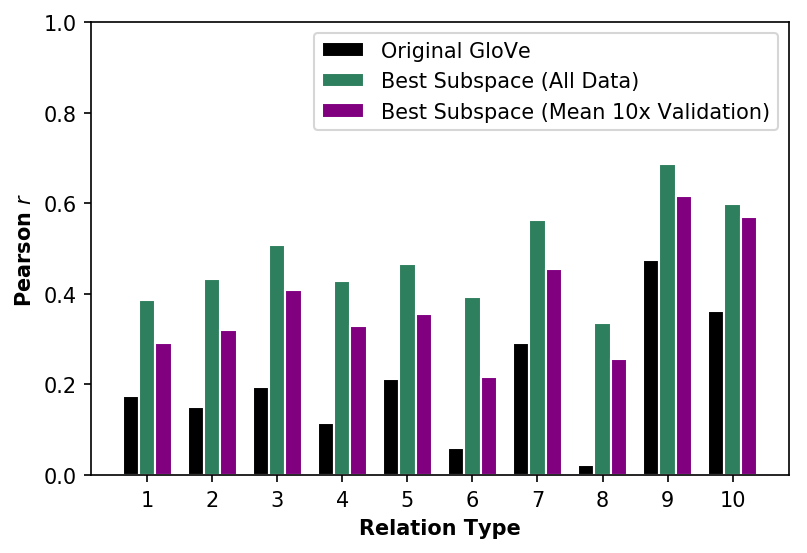

In [286]:
plt.figure(dpi=150)

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = all_base_scores
bars2 = all_best_scores
bars3 = val_best_scores
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='black', width=barWidth, edgecolor='white', 
        label='Original GloVe')
plt.bar(r2, bars2, color='#2d7f5e', width=barWidth, edgecolor='white', 
        label='Best Subspace (All Data)')
plt.bar(r3, bars3, color='purple', width=barWidth, edgecolor='white', 
        label='Best Subspace (Mean 10x Validation)')
 
# Add xticks on the middle of the group bars
# plt.xlabel('group', fontweight='bold')
plt.ylabel('Pearson $r$', fontweight='bold')
plt.xlabel('Relation Type', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], range(1, 11))

plt.ylim([0,1])

# Create legend & Show graphic
plt.legend()
plt.show()

In [303]:
exp_params = (df_rel_sim.rel1_type==2) & (df_rel_sim.rel2_type==2)

df_rel_sim[exp_params]

,relation1,relation2,comparison_type,pair1_word1,pair1_word2,pair2_word1,pair2_word2,mean_rating,num_ratings,rel1_type,rel2_type,preds,in_vocab
17,2a,2a,within-subtype,dance,step,foot,toe,4.300000,10,2,2,-8.433628,True
20,2a,2b,between-subtype,shoe,sole,team,player,5.200000,10,2,2,-8.789095,True
23,2a,2b,between-subtype,bookcase,shelf,herd,antelopes,3.615385,13,2,2,-9.538898,True
33,2a,2a,within-subtype,computer,mouse,lips,mouth,3.230769,13,2,2,-8.288046,True
48,2a,2b,between-subtype,cat,whiskers,pack,wolf,2.900000,10,2,2,-9.484206,True
99,2a,2a,within-subtype,fish,fin,zebra,stripes,6.100000,10,2,2,-7.762939,True
102,2a,2a,within-subtype,bird,feathers,bouquet,flower,6.000000,11,2,2,-7.791229,True
120,2a,2b,between-subtype,foot,toe,senate,senators,4.823529,17,2,2,-6.368216,True
123,2a,2b,between-subtype,bedroom,bed,flock,bird,4.727273,11,2,2,-7.615473,True
131,2b,2a,between-subtype,aquarium,fish,eye,lashes,5.200000,10,2,2,-9.348969,True
